# Map of Selected Routes

## Weekdays

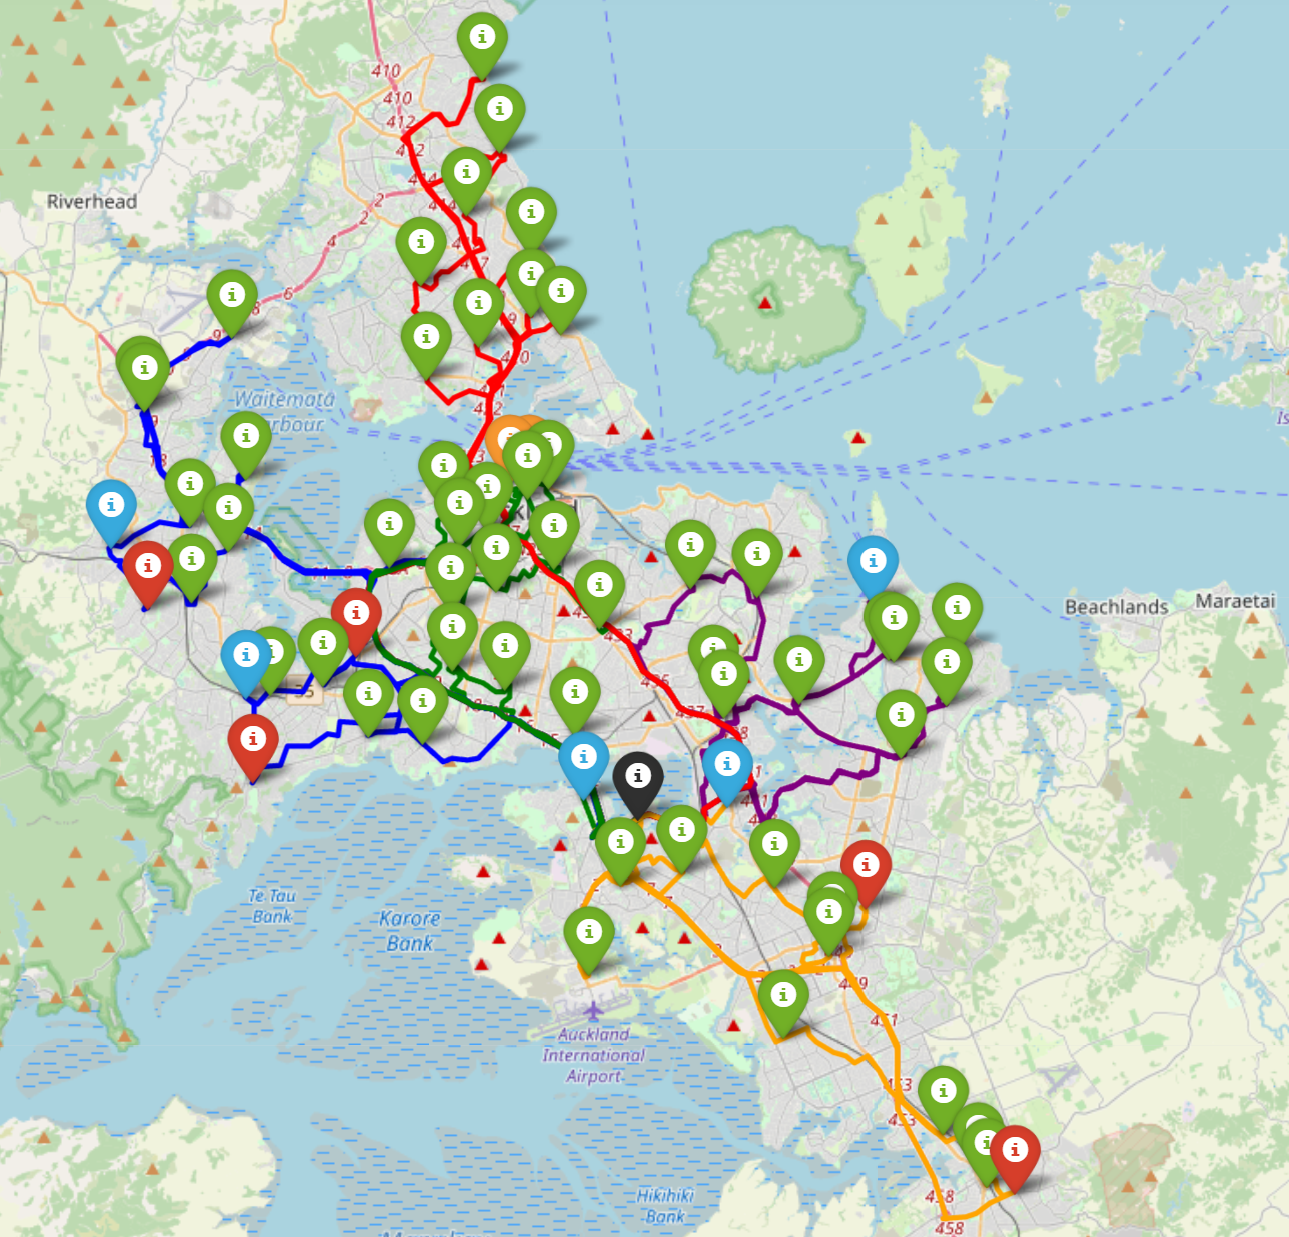

## Saturdays

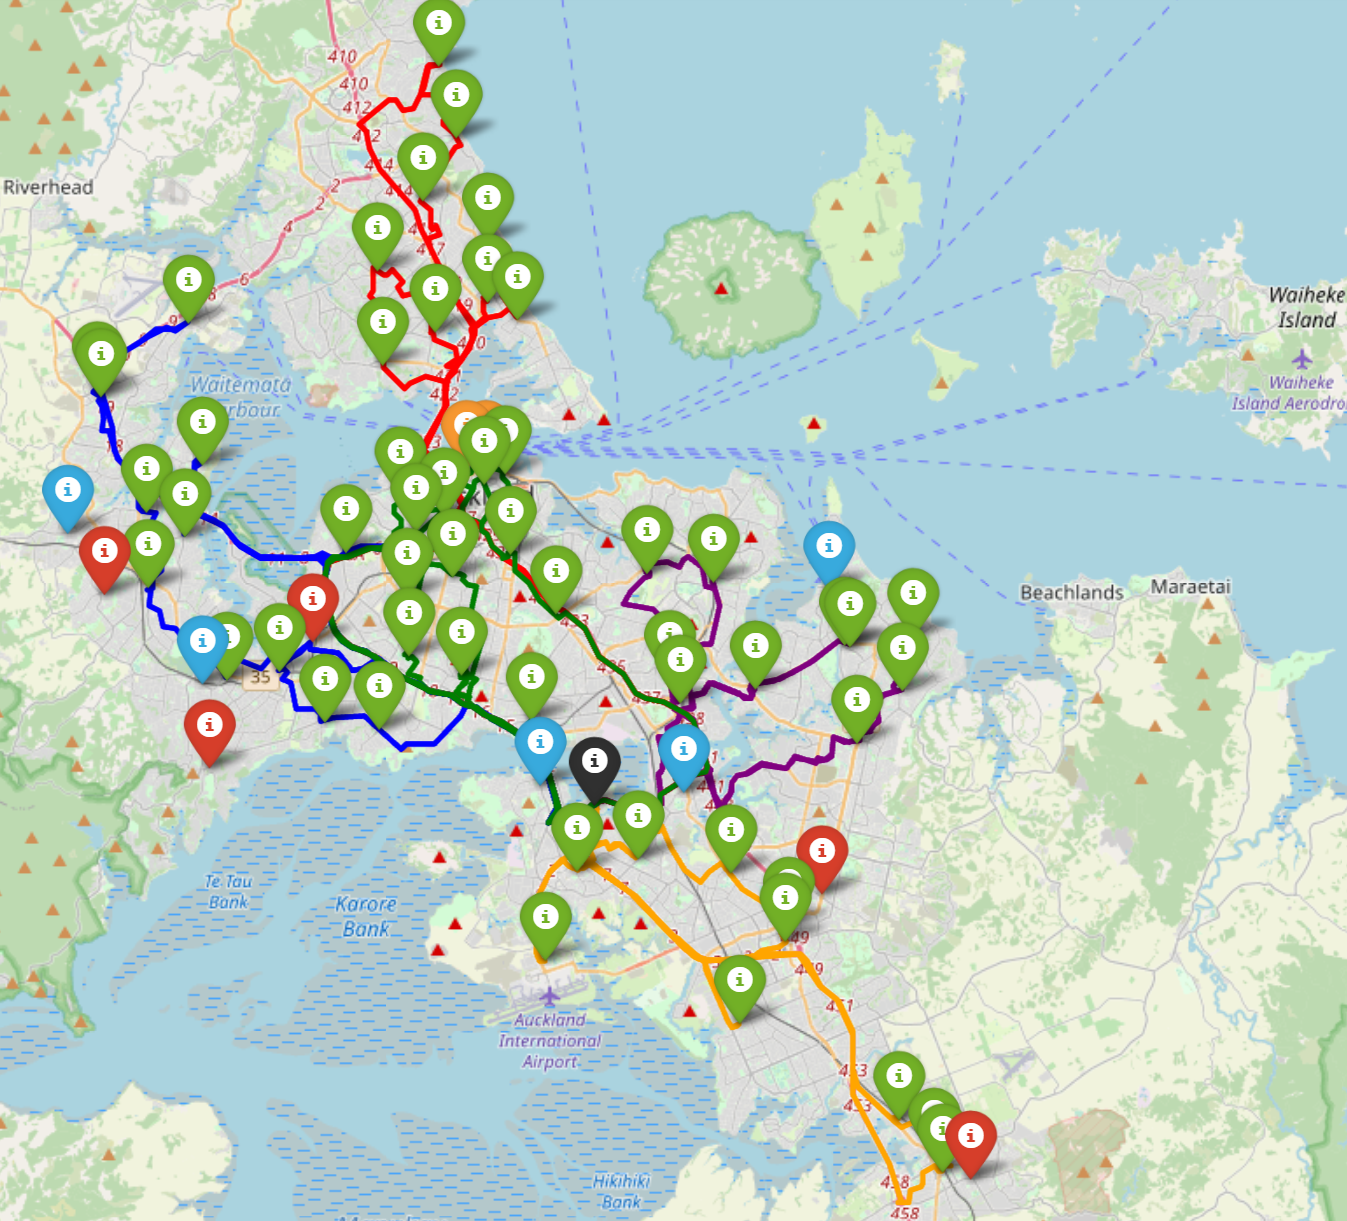

The colour of the lines indicate the regions that the stores are in which the route is delivering pallets to.

# Simulation and Initial Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pickle
from Simulation import getCost

In [2]:
# demands table
demandData = pd.read_csv("Data/WoolworthsDemands.csv", index_col="Store").transpose()
demandData.index = pd.to_datetime(demandData.index)  
weekdays = demandData.loc[(demandData.index.weekday!=5) & (demandData.index.weekday!=6)].transpose()
saturdays = demandData.loc[demandData.index.weekday==5].transpose()

# adjacency matrix
adj = pd.read_csv("Data/WoolworthsTravelDurations.csv", index_col=0)
# routes
satRoutes = pd.read_csv("GeneratedFiles/SaturdaysSolution.csv")["Path"]
weekRoutes = pd.read_csv("GeneratedFiles/WeekdaysSolution.csv")["Path"]

satRoutes = [satRoutes[i][2:-2].split("', '") for i in range(len(satRoutes))]
weekRoutes = [weekRoutes[i][2:-2].split("', '") for i in range(len(weekRoutes))]

satExp = pd.read_csv("GeneratedFiles/SaturdaysSolution.csv")["Total Cost"].tolist()[0]
weekExp = pd.read_csv("GeneratedFiles/WeekdaysSolution.csv")["Total Cost"].tolist()[0]

## Sampling of Total Costs
We first sample the cost to get a distribution of the total costs

In [3]:
iterations = 1000

weekCosts = [np.sum([getCost(path, adj, weekdays) for path in weekRoutes]) for i in range(iterations)]
satCosts = [np.sum([getCost(path, adj, saturdays) for path in satRoutes]) for i in range(iterations)]

IndexError: list index out of range

In [ ]:
satLabel = "p-value = {:.2f}".format(stats.ttest_1samp(satCosts, satExp)[1])
weekLabel = "p-value = {:.2f}".format(stats.ttest_1samp(weekCosts, weekExp)[1])

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(satCosts, density=True, histtype="stepfilled", alpha=0.2, bins=12)
ax1.plot([], color="white", label=satLabel)
ax1.axvline(satExp, color='r', linestyle='dashed', linewidth=1, label="Initial Estimate")
ax1.axvline(np.mean(satCosts), color='b', linestyle='dashed', linewidth=1, label="Mean")
ax1.set_title('Saturdays')
ax1.set_xlabel("Cost per Saturdays [$]")
ax1.legend(frameon=False)

ax2.hist(weekCosts, density=True, histtype="stepfilled", alpha=0.2, bins=12)
ax2.plot([], color="white", label=weekLabel)
ax2.axvline(weekExp, color='r', linestyle='dashed', linewidth=1, label="Initial Estimate")
ax2.axvline(np.mean(weekCosts), color='b', linestyle='dashed', linewidth=1, label="Mean")
ax2.set_title("Weekdays")
ax2.set_xlabel("Cost per Weekday [$]")
ax2.legend(frameon=False)

fig.tight_layout()

plt.show()

In the above histogram we see the distribution of the costs for our routes after a thousand simulations.

For our Saturdays' routes we see that the distribution is symmetric and our initial estimate is at the upper bound of the distribution. This is due to rounding up the average demands used in our LP which meant our model solved for demands that are higher than the actual average.

For our Weekdays' routes we see that the distribution is skewed to the right and is bimodal. The mean of the distribution is close to our initial estimate but is slightly higher due to not accounting for overtime and freight hiring costs in our initial LP.

From our distribution we can generate a 95% confidence interval for our costs.

In [6]:
weekCosts.sort()
lwr, uppr = weekCosts[24], weekCosts[974]
f"Lower: {round(lwr, 2)}, Upper : {round(uppr, 2)}"

'Lower: 19135.43, Upper : 25728.9'

In [7]:
satCosts.sort()
lwr, uppr = satCosts[24], satCosts[974]
f"Lower: {round(lwr, 2)}, Upper : {round(uppr, 2)}"

'Lower: 10038.94, Upper : 10967.06'

In [10]:
19135.43 * 5 + 10038.94

105716.09

In [11]:
25728.9 * 5 + 10967.06

139611.56

In a typical week, we can estimate that our routes will cost between 105716.09 and 139611.56 dollars.